# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## 1.DATA EXPLORATION

In [5]:
print('The Azdias data, which is the german population data has {} rows and {} columns'.format(azdias.shape[0], azdias.shape[1]))
azdias.head()

The Azdias data, which is the german population data has 891221 rows and 366 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
print('The customer data has {} rows and {} columns'.format(customers.shape[0], customers.shape[1]))
customers.head()

The customer data has 191652 rows and 369 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
azdias.describe(include='all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000


## 2.converting Unknown values into Nan
The first step is to address unknown values. Here, uknown values exist as Nan values and additionally each column has their own designation for unknown records. Hence, the first task is to figure out, for each column, what is used to represent unknown values and change those values to Nan. The Dias Attribute file containes this information.

In [8]:
# finding the designations that might be eligble for Nan imputation.
features = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1, usecols = [1,2,3,4])
#features[features['Meaning']=='unknown']
features[features['Attribute'].notnull()]['Meaning'].unique()

array(['unknown', 'unknown / no main age detectable',
       'numeric value (typically coded from 1-10)',
       'numeric value (typically coded from 1-3)', 'Work-Life-Balance',
       'no transactions known',
       'highest activity within the last 12 months',
       'no transaction known',
       'no Online-transactions within the last 12 months', 'Universal',
       'business cell', 'numeric value', 'Event travelers',
       "doesn't belong to the green avantgarde", 'very low car quote',
       'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell',
       'single ', 'single low-income earners of younger age',
       'single low-income- and average earners of younger age ',
       'typical low-income earners', 'low-income earners',
       'very high mobility', 'none', 'mainly 1-2 family homes',
       'very low'], dtype=object)

In [9]:
# the following Meaning indicate the absence of records
def unknown_finder(col):
    unknowns = ['unknown', 'unknown / no main age detectable',
               'no transactions known',
               'no transaction known', 
                'none']
    if col['Meaning'] in unknowns:
        ans = True
    else:
        ans =False
    return ans

In [10]:
potential_null =features[features['Attribute'].notnull()]

In [11]:
potential_null.set_index('Attribute', inplace=True)

In [12]:
potential_null

,Description,Value,Meaning
Attribute,,,
AGER_TYP,best-ager typology,-1,unknown
ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
ALTER_HH,main age within the household,0,unknown / no main age detectable
ANREDE_KZ,gender,"-1, 0",unknown
ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
...,...,...,...
WOHNDAUER_2008,length of residence,"-1, 0",unknown
WOHNLAGE,residential-area,-1,unknown
WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown


In [13]:
# finding the values of the unknown for each columns that include unknown values in a form other than Nan.
potential_null = potential_null[potential_null.apply(unknown_finder, 1)]
#potential_null['Value'].astype(str)[5].split(',')
d = {}
for i in potential_null.index:
    value = potential_null.loc[i]['Value']
    if type(value)==str:
        d[str(i)] = [int(l) for l in value.split(', ')]
    else:
        d[str(i)] = [value]
    
d   

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_BANKEN_ANZ_12': [0],
 'D19_BANKEN_ANZ_24': [0],
 'D19_BANKEN_DIREKT_RZ': [0],
 'D19_BANKEN_GROSS_RZ': [0],
 'D19_BANKEN_LOKAL_RZ': [0],
 'D19_BANKEN_REST_RZ': [0],
 'D19_BEKLEIDUNG_GEH_RZ': [0],
 'D19_BEKLEIDUNG_REST_RZ': [0],
 'D19_BILDUNG_RZ': [0],
 'D19_BIO_OEKO_RZ': [0],
 'D19_BUCH_RZ': [0],
 'D19_DIGIT_SERV_RZ': [0],
 'D19_DROGERIEARTIKEL_RZ': [0],
 'D19_ENERGIE_RZ': [0],
 'D19_FREIZEIT_RZ': [0],
 'D19_GARTEN_RZ': [0],
 'D19_GESAMT_ANZ_12': [0],
 'D19_GESAMT_ANZ_24': [0],
 'D19_HANDWERK_RZ': [0],
 'D19_HAUS_DEKO_RZ': [0],
 'D19_KINDERARTIKEL_RZ': [0],
 'D19_KK_KUNDENTYP': [-1],
 'D19_KOSMETIK_RZ': [0],
 'D19_LEBENSMITTEL_RZ': [0],
 'D19_LOTTO_RZ': [0],
 'D19_NAHRUNGSERGAENZUNG_RZ': [0],
 'D19_RATGEBER_RZ': [0],
 'D19_REISEN_RZ': [0],
 'D19_SAMMELARTIKEL_RZ': [0],
 'D19

In [14]:
az = azdias.copy()


In [15]:
#now that unkown value representations are known for each column, we impute them using np.nan 
for (key, value) in d.items():
    try:
        az[key].replace(d[key], np.nan, inplace=True)
    except:
        print('{}: attribute is not in population data'.format(key))
        continue

BIP_FLAG: attribute is not in population data
CAMEO_DEUINTL_2015: attribute is not in population data
D19_BANKEN_DIREKT_RZ: attribute is not in population data
D19_BANKEN_GROSS_RZ: attribute is not in population data
D19_BANKEN_LOKAL_RZ: attribute is not in population data
D19_BANKEN_REST_RZ: attribute is not in population data
D19_BEKLEIDUNG_GEH_RZ: attribute is not in population data
D19_BEKLEIDUNG_REST_RZ: attribute is not in population data
D19_BILDUNG_RZ: attribute is not in population data
D19_BIO_OEKO_RZ: attribute is not in population data
D19_BUCH_RZ: attribute is not in population data
D19_DIGIT_SERV_RZ: attribute is not in population data
D19_DROGERIEARTIKEL_RZ: attribute is not in population data
D19_ENERGIE_RZ: attribute is not in population data
D19_FREIZEIT_RZ: attribute is not in population data
D19_GARTEN_RZ: attribute is not in population data
D19_HANDWERK_RZ: attribute is not in population data
D19_HAUS_DEKO_RZ: attribute is not in population data
D19_KINDERARTIKEL_R

## 3. Data Exploration
The composition of the dataset will be xplored and visualized. The percentage of Nan values will be analysed for each row and column to decide between imputation and dropping of the column/row.

In [16]:
#counting the percentage of Nan values for each column and ranking them accordingly
nan_count = az.isnull().mean()*100
nan_df = nan_count.to_frame().sort_values(by=0, axis=0, ascending=False)
nan_df = nan_df[:50].T
nan_df

,ALTER_KIND4,TITEL_KZ,ALTER_KIND3,ALTER_KIND2,D19_TELKO_ANZ_12,D19_BANKEN_ANZ_12,D19_TELKO_ANZ_24,D19_VERSI_ANZ_12,ALTER_KIND1,D19_BANKEN_ANZ_24,...,KBA05_CCM3,KBA05_HERST2,KBA05_HERST1,KBA05_KRSHERST2,KBA05_CCM1,KBA05_ALTER2,KBA05_FRAU,KBA05_DIESEL,KBA05_CCM4,KBA05_ALTER1
0,99.864792,99.757636,99.307691,96.690047,96.271295,93.325225,92.705176,92.153237,90.904837,89.102479,...,16.618774,16.618774,16.618774,16.618774,16.618774,16.618774,16.618774,16.618774,16.618774,16.618774


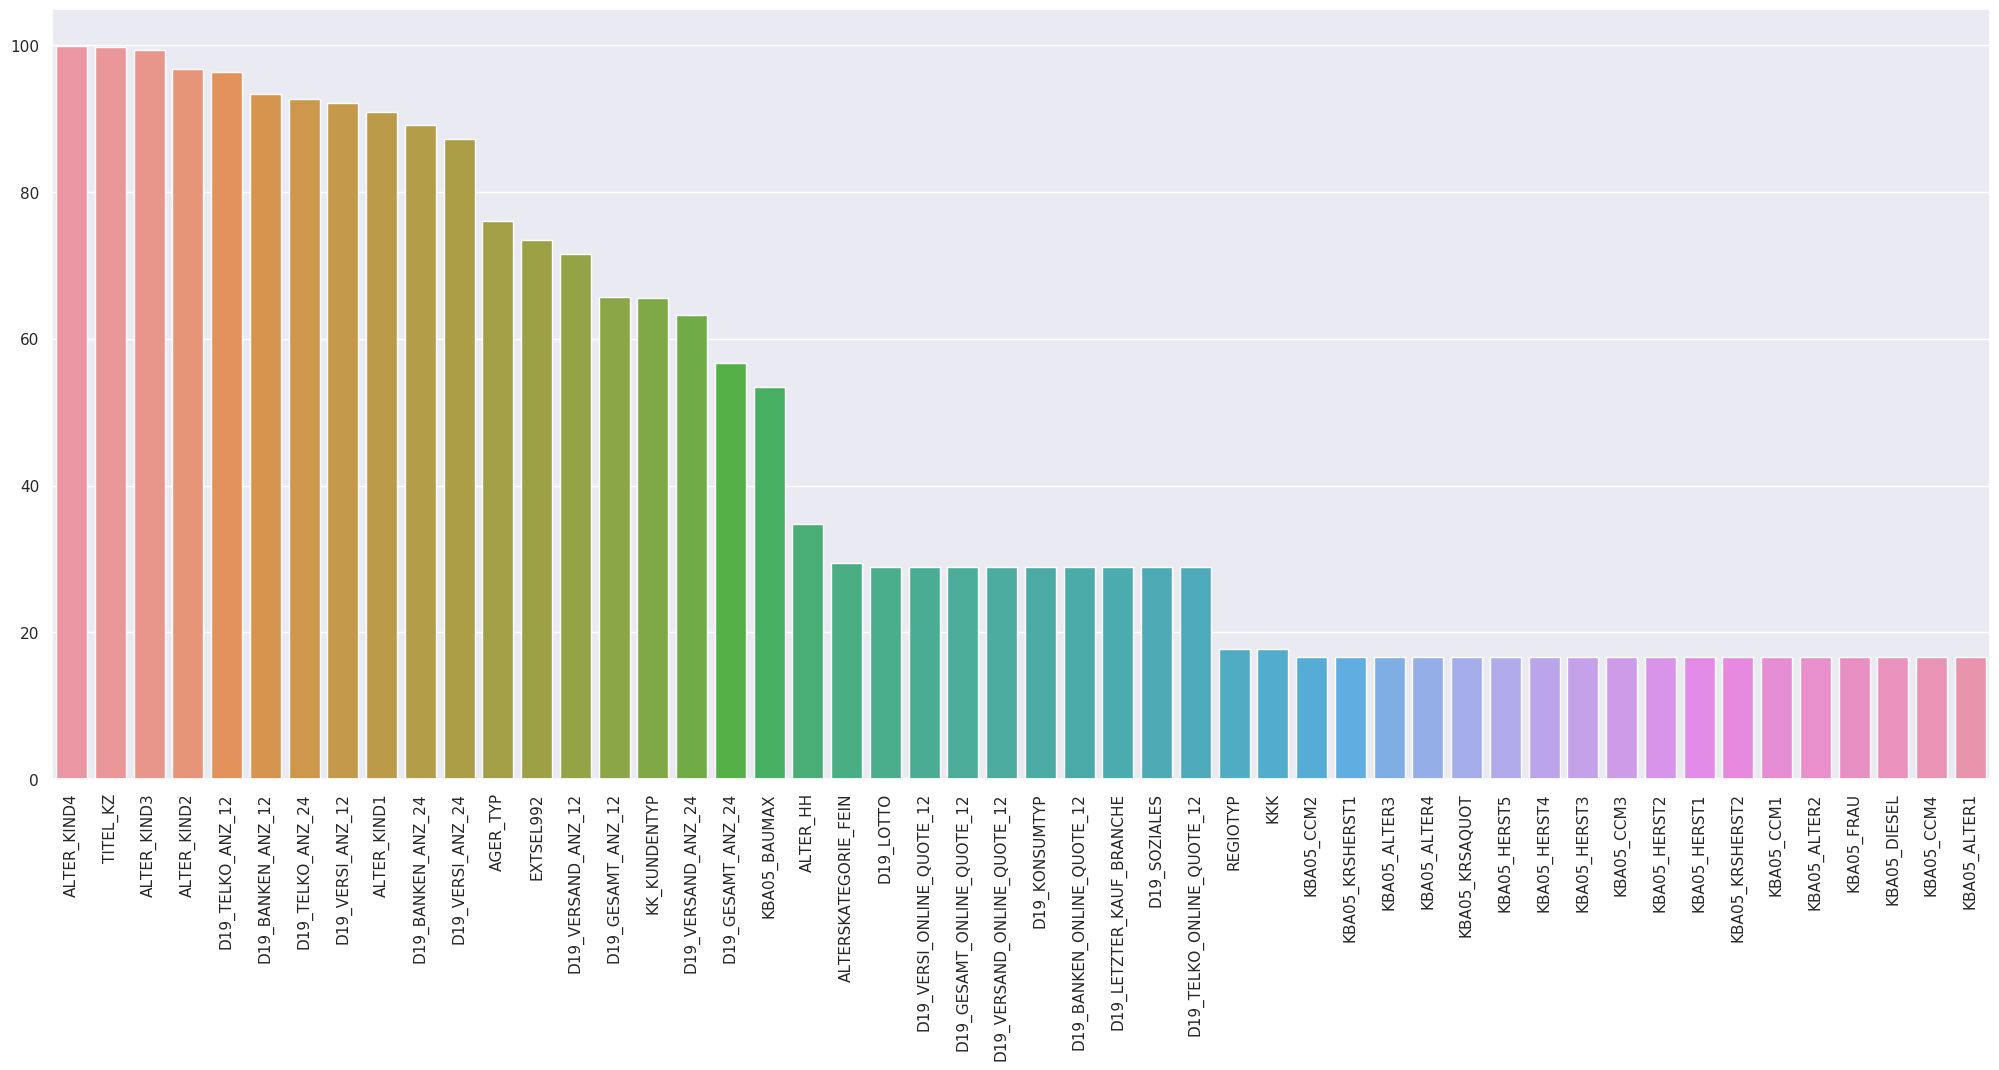

In [17]:
sns.set(rc={'figure.figsize': (25, 10)})
sns.barplot(data = nan_df)
plt.xticks(rotation=90);

a. we can observe that among 365 columns, more than 20 columns has 20% or more of their records missing. For the rest of the columns missing values are less than 20%.

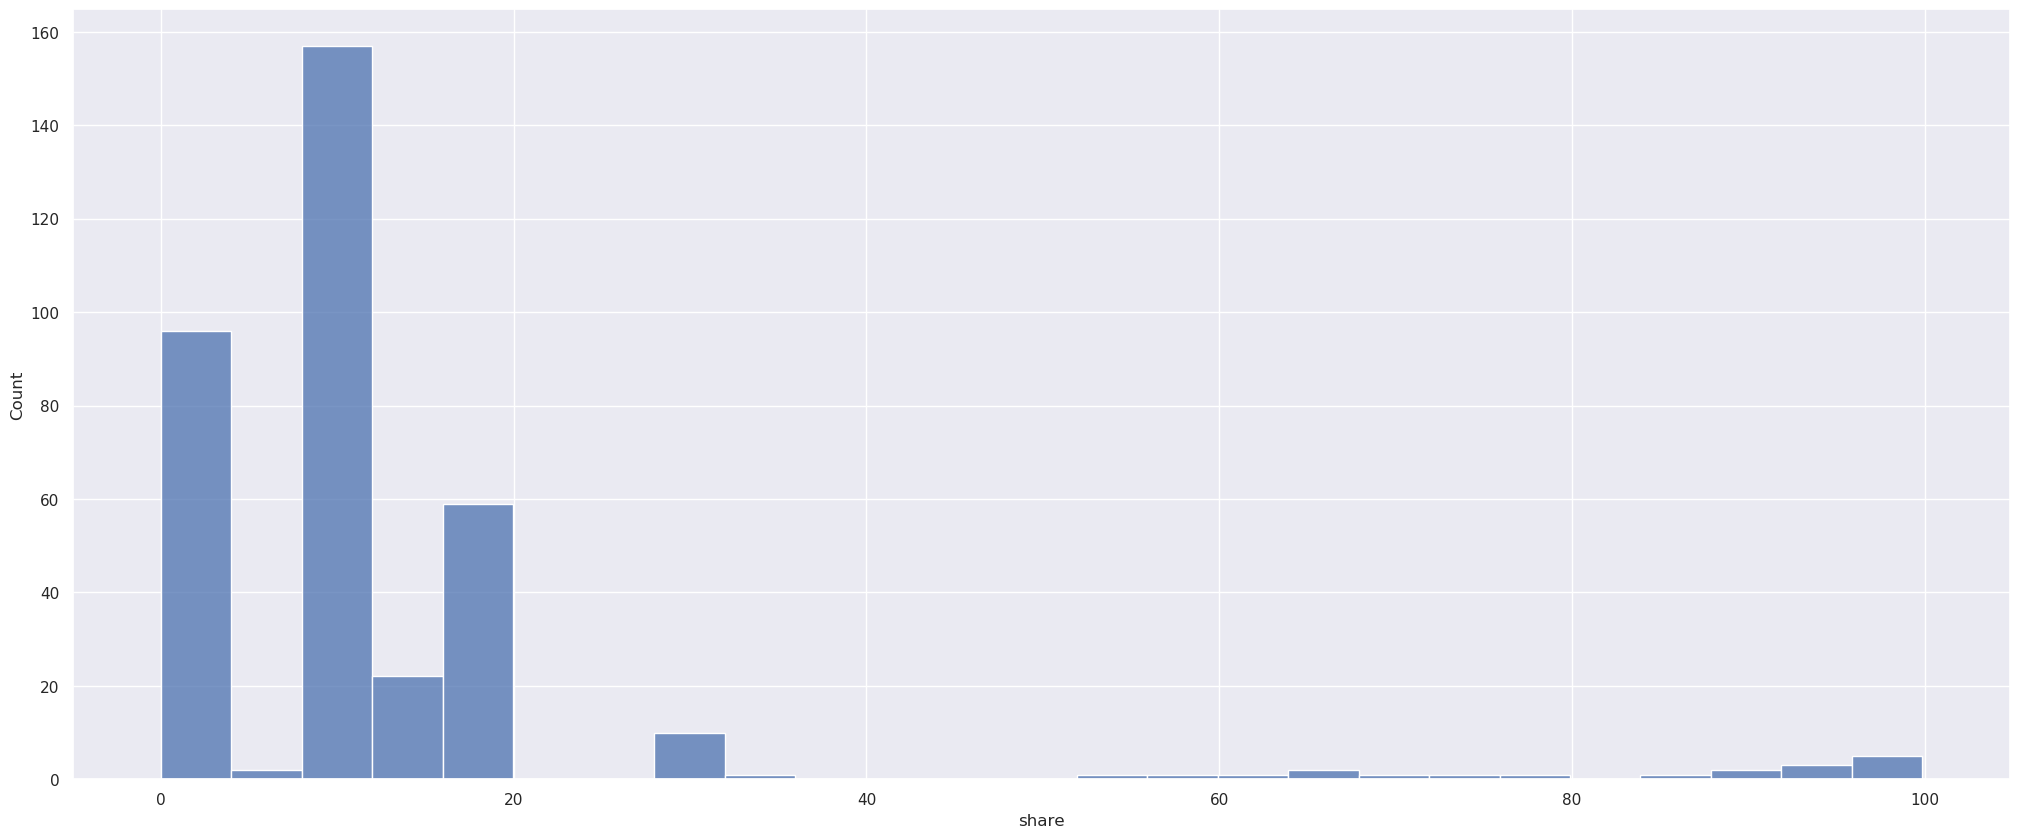

In [18]:
cnt = az.isnull().mean()*100
az_null_share = pd.DataFrame({'share':cnt}).sort_values(by='share',ascending=False).reset_index()
sns.histplot(az_null_share['share'])

If we visualize the percentage of unkown values with respect to the number of columns. we can see that the majority of columns has only less than 40% of their records missing.

In [19]:
#pip install seaborn --upgrade

In [20]:
az_null_share

,index,share
0,ALTER_KIND4,99.864792
1,TITEL_KZ,99.757636
2,ALTER_KIND3,99.307691
3,ALTER_KIND2,96.690047
4,D19_TELKO_ANZ_12,96.271295
...,...,...
361,D19_TELKO_MOBILE,0.000000
362,D19_TELKO_DATUM,0.000000
363,D19_TECHNIK,0.000000
364,D19_SONSTIGE,0.000000


In [21]:
# dropping columns that has more than 40% of their records missing.
kept_columns = az_null_share[az_null_share['share']<40]['index']
az = az[kept_columns]
az.shape

(891221, 347)

## Row wise

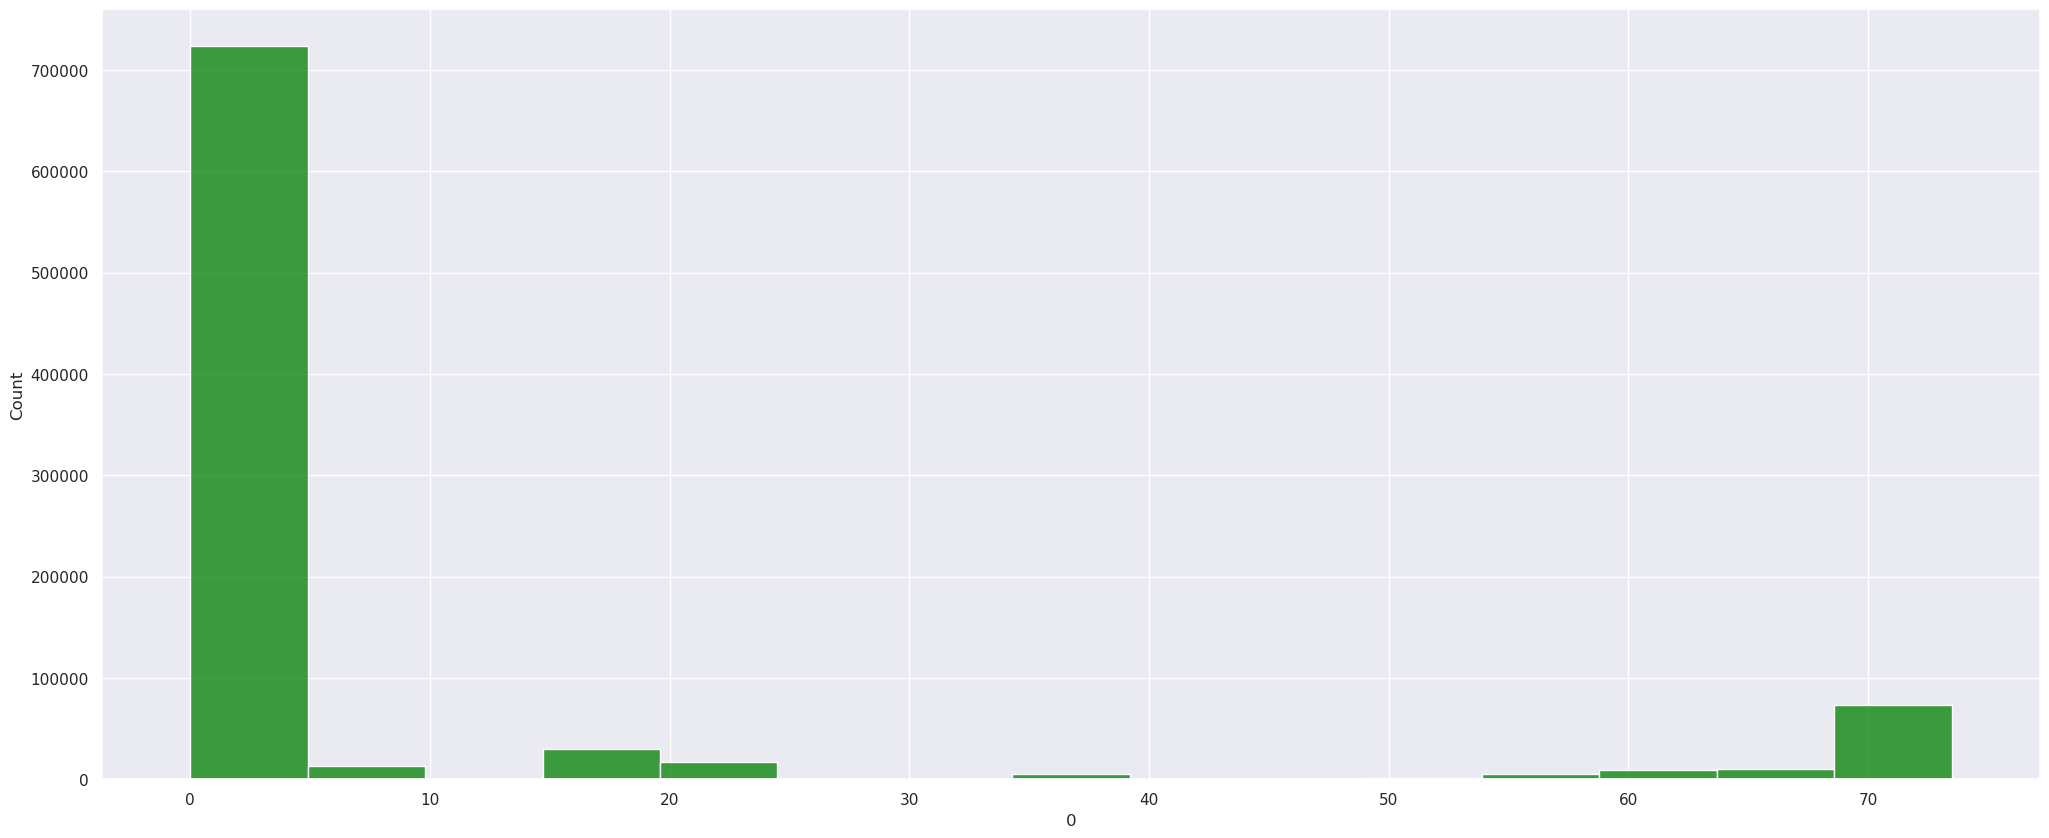

In [22]:
row_nan_cnt = az.isnull().mean(axis=1)*100
row_nan_df = row_nan_cnt.to_frame().sort_values(by=0, ascending=False)
sns.set(rc={'figure.figsize': (25, 10)})
sns.histplot(row_nan_df[0], bins=15, color='green')

The majority of the rows has only less than 10% of their columns missing hence, we can use 10 as a threshhold for dropping.

In [23]:
#dropping the rows with morethan 10% values missing
az = az[row_nan_cnt<10]


In [24]:
az.dtypes.value_counts()

float64    264
int64       77
object       6
dtype: int64

## 4. Data preprocessing
categorical columns will be analysed and manipulated accordingly

In [25]:
#finding categorical columns
categ_columns = az.dtypes[az.dtypes=='object'].index
categ_columns

Index(['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015',
       'CAMEO_DEUG_2015', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [26]:
az[categ_columns].describe()

,D19_LETZTER_KAUF_BRANCHE,CAMEO_DEU_2015,CAMEO_INTL_2015,CAMEO_DEUG_2015,EINGEFUEGT_AM,OST_WEST_KZ
count,573215,734125,734125,734125,737180,737180
unique,35,45,43,19,2819,2
top,D19_UNBEKANNT,6B,51,8,1992-02-10 00:00:00,W
freq,179081,53997,73250,74746,372198,582196


In [27]:
for col in categ_columns:    
    print(col,' has this values: ', az[col].unique())


D19_LETZTER_KAUF_BRANCHE  has this values:  [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_SONSTIGE' 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_FREIZEIT' 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG'
 'D19_BANKEN_LOKAL']
CAMEO_DEU_2015  has this values:  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_INTL_2015  has this values:  [51.0 24.0 12.0 43.0 54.0 22.0 14

* CAMEO_DEU_2015 contains detailed information about the population. The information in CAMEO_INTL_2015 is contained in CAMEO_DEU_2015 hence removing this column won't result in significant loss of important information.Hence, this column would be dropped.
* The D19_LETZTER_KAUF_BRANCHE attribute containes 35 categories. Since the essence of this attribute is not given in the DIAS file, it is better to drop it. We dont know what the categories represent and there is too many of them which complicates the dataset.
* OST_WEST_KZ is simple as it containes two categories and can be encoded into zero and one.

* EINGEFUEGT_AM is a datetime attribute encoded as categorical.Hence, we would convert it to datetime column. 
* CAMEO_DEUG_2015 containes 18 categories which can be converted to integers.

In [28]:
az.drop(['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE'],axis=1, inplace=True)

Replacing X and XX values with NAN

In [29]:
import numpy
az['CAMEO_DEU_2015'] = az['CAMEO_DEU_2015'].replace('XX', np.nan)
az['CAMEO_DEUG_2015'] = az['CAMEO_DEUG_2015'].replace('X', np.nan)
az['CAMEO_DEUG_2015'] = az['CAMEO_DEUG_2015'].astype(float)

The OST_WEST_KZ attribute has only two categories and they would be encoded to 0 and 1.


In [30]:
az['OST_WEST_KZ'] = az['OST_WEST_KZ'].map({'W':0, 'E':1})

In [31]:
#convert to datetime
az["EINGEFUEGT_AM"] = pd.to_datetime(az["EINGEFUEGT_AM"])
az["EINGEFUEGT_AM"] = az['EINGEFUEGT_AM'].map(lambda x: x.year)

In [32]:
az.shape

(737180, 345)

We would repeat the above steps for customer data


In [41]:
cust = customers.copy()


In [42]:
def customer_processor(az, d):
    for (key, value) in d.items():
        try:
            az[key].replace(d[key], np.nan, inplace=True)
        except:
            #print('{}: attribute is not in customer data'.format(key))
            continue

    cnt = az.isnull().mean()*100
    az_null_share = pd.DataFrame({'share':cnt}).sort_values(by='share',ascending=False).reset_index()
    kept_columns = az_null_share[az_null_share['share']<40]['index']
    az = az[kept_columns]

    row_nan_cnt = az.isnull().mean(axis=1)*100
    row_nan_df = row_nan_cnt.to_frame().sort_values(by=0, ascending=False)
    az = az[row_nan_cnt<10]

    az.drop(['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'],axis=1, inplace=True) #
    #az.drop(['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE'],axis=1, inplace=True) #, 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'

    az['CAMEO_DEU_2015'] = az['CAMEO_DEU_2015'].replace('XX', np.nan)
    az['CAMEO_DEUG_2015'] = az['CAMEO_DEUG_2015'].replace('X', np.nan)
    az['CAMEO_DEUG_2015'] = az['CAMEO_DEUG_2015'].astype(float)
    az['OST_WEST_KZ'] = az['OST_WEST_KZ'].map({'W':0, 'E':1})

    az["EINGEFUEGT_AM"] = pd.to_datetime(az["EINGEFUEGT_AM"])
    az["EINGEFUEGT_AM"] = az['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return az



In [43]:
cust = customer_processor(cust, d)

In [44]:
cust.shape

(134240, 345)

## Feature Engineering, Imputing Nan values, One hot encoding, and Scaling of features
In this section nan values will be imputed with proper values and categorical values would be one hot encoded. Columns with numerical values would be scaled to allow for fast convergence of the later algorithms.


In [37]:
az.dtypes.value_counts()

float64    266
int64       78
object       1
dtype: int64

In [38]:
categorical_columns = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
binary_clmns=['VERS_TYP', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'KBA05_SEG6', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'SOHO_KZ', 'ANREDE_KZ',
 'GREEN_AVANTGARDE']
numerical_columns = list(set(az.columns) - set(categorical_columns) - set(binary_clmns))

#### Scikitlearns's ColumnTransformer is used to apply the transformation needed over each column, sklearn's pipeline object is also used to sequentially apply a list of transforms for each column types(categorical, numerical, and binary).

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder

In [40]:
categorical_pipeline = Pipeline([('categorical_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                                ('One_hot_encoder',OneHotEncoder(handle_unknown='ignore') )])
numerical_pipeline = Pipeline([('numerical_imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
                                ('numerical_scaler',StandardScaler() )])
binary_pipeline = Pipeline([('binary_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [45]:
column_transformer = ColumnTransformer(
    transformers = [
        ('categorical', categorical_pipeline, categorical_columns), 
        ('numerical', numerical_pipeline, numerical_columns ), 
        ('binary', binary_pipeline, binary_clmns)
    
])
az[categorical_columns] = az[categorical_columns].astype(str)
az = column_transformer.fit_transform(az)

In [46]:
hot_encoded_columns = list(column_transformer.transformers_[0][1].named_steps['One_hot_encoder'].get_feature_names(categorical_columns))
columns = hot_encoded_columns + numerical_columns + binary_clmns
az = pd.DataFrame(az, columns=[columns])

In [47]:
az.dtypes.value_counts()

float64    398
dtype: int64

### Repeating the above transformation for the customers dataset


In [48]:
cust[categorical_columns] = cust[categorical_columns].astype(str)
cust = column_transformer.fit_transform(cust)

In [49]:
hot_encoded_columns = list(column_transformer.transformers_[0][1].named_steps['One_hot_encoder'].get_feature_names(categorical_columns))
columns = hot_encoded_columns + numerical_columns + binary_clmns
cust = pd.DataFrame(cust, columns=[columns])

In [50]:
cust.dtypes.value_counts()

float64    398
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality reduction
AS we have more than 390 features, it is important that we reduce the number of features by retaining only the essential parts. PCA is a widely used technique to do this task
### Principal Component Analysis(PCA)
PCA can help by reducing the number of features in the dataset while retaining the most important information. It does this by finding the directions of maximum variance in the data and projecting the data onto a lower-dimensional space. This new space has fewer dimensions, which makes it easier to analyze the data and find patterns or relationships

In [51]:
from sklearn.decomposition import PCA
pca = PCA()
az_pca = pca.fit(az)


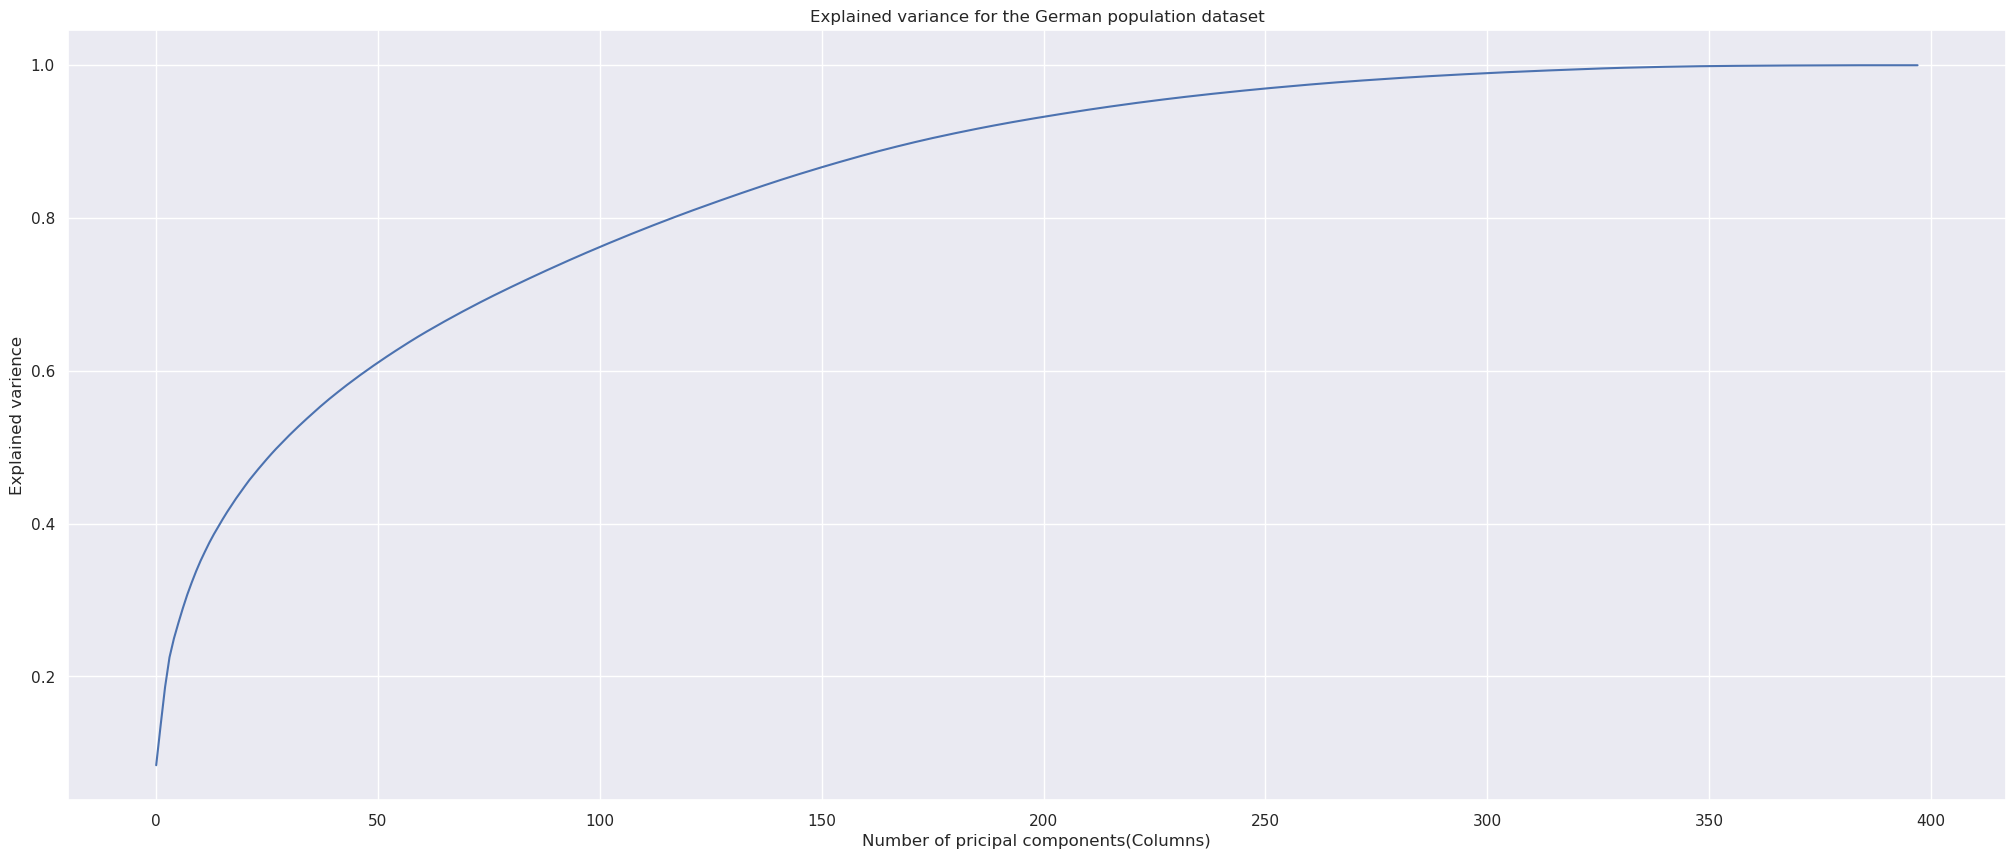

In [52]:
sns.lineplot(np.cumsum(pca.explained_variance_ratio_), sizes = (10, 15))
plt.xlabel('Number of pricipal components(Columns)')
plt.ylabel('Explained varience')
plt.title('Explained variance for the German population dataset')
plt.show()

From the plot, we can see that more than 90% of the variance can be explaiened with just 200 features. Hence, we can take the 200 most essential attributes while retaining more than 90% of the information. The trade off is beneficial as we could reduce the dataset in half while only losing less than 10% of information.

In [53]:
reduced_pca = PCA(n_components=200).fit(az)
reduced_az = pd.DataFrame(reduced_pca.transform(az))

In [54]:
reduced_pcac = PCA(n_components=200).fit(cust)
reduced_cust = pd.DataFrame(reduced_pcac.transform(cust))

# k-Means for German population dataset
 K-means clustering will be used to group people based on their demographic characteristics. This will help us identify patterns and trends in the population which we will compare against our already existing customers. The elbow method will be used to determine the optimum number of clusters.
 

In [55]:
from sklearn.cluster import KMeans
sse = []
for i in range(3, 51):
    k = KMeans(n_clusters=i, init='k-means++')
    k.fit(reduced_az.sample(15000))
    
    sse.append(k.inertia_)
    

Text(0, 0.5, 'Sum squared error')

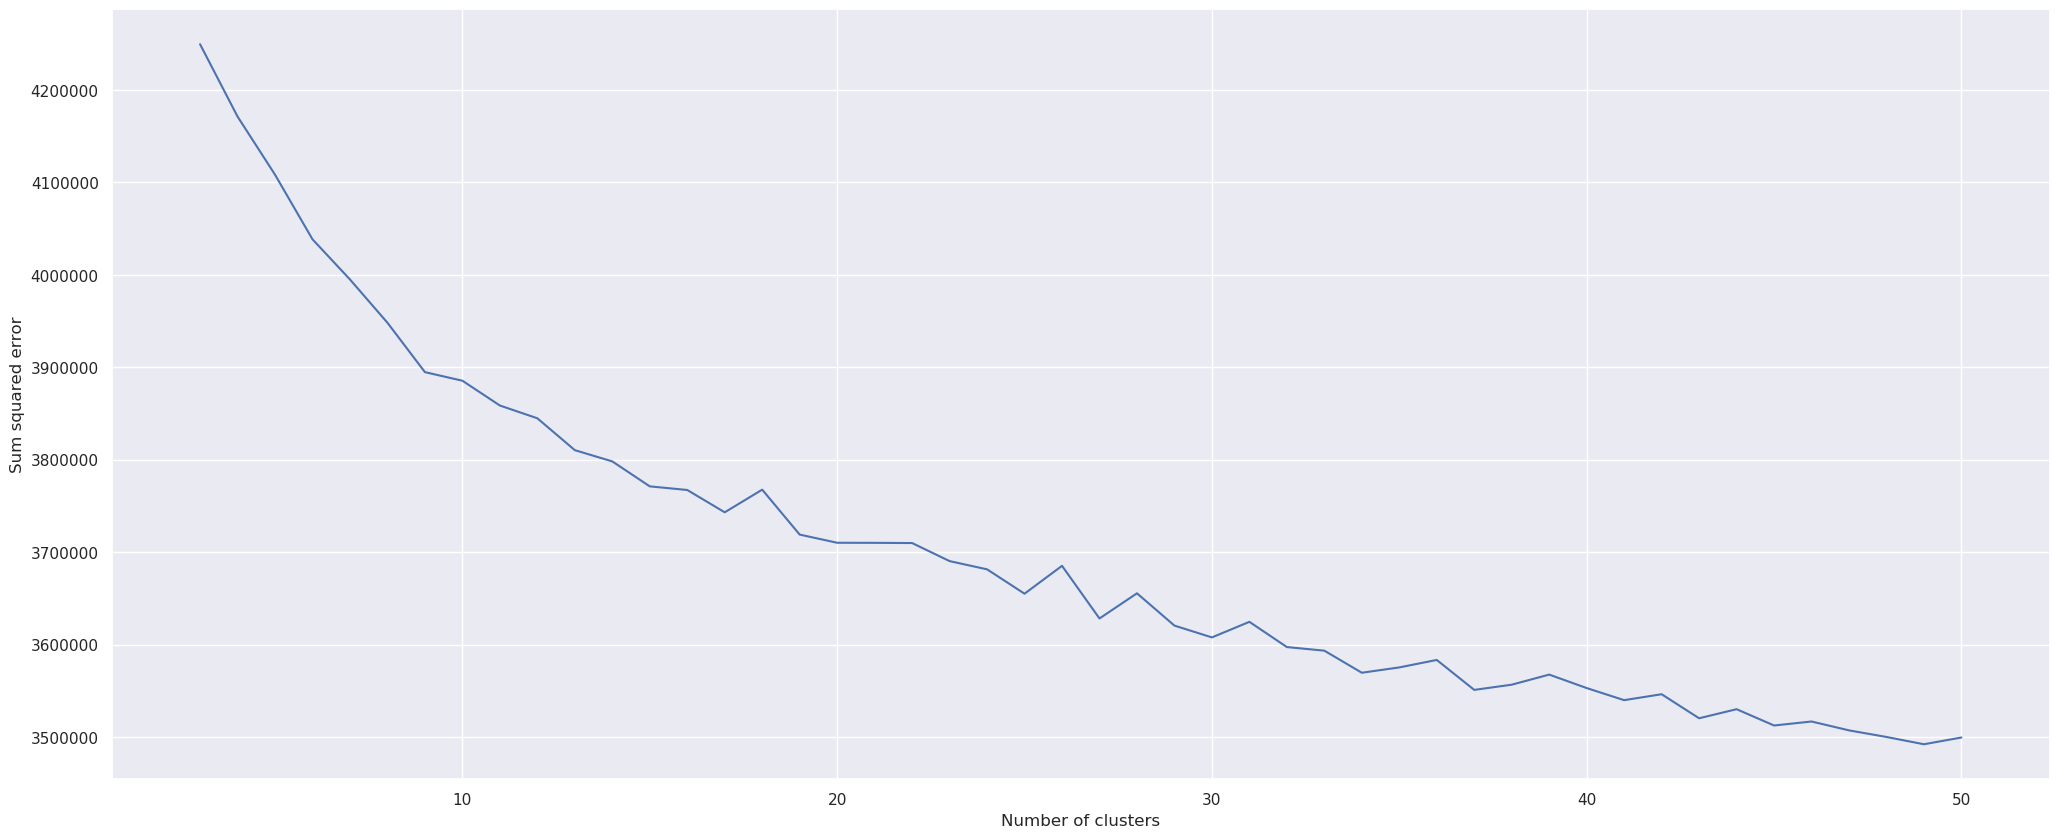

In [56]:
plt.plot(list(range(3, 51)), sse)#, size=(10, 10))
plt.xlabel('Number of clusters')
plt.ylabel('Sum squared error')


As the dataset is complex and containes many features, it is not completely clear where the elbow exist. However, it can be observed that there was steep descrees in the squared error until around the cluster number 12. Hence, 12 will be taken as the optimum number of clusters.

In [57]:
n_clusters =12
kmeans = KMeans(n_clusters)
az_clusters = kmeans.fit_predict(reduced_az)

In [58]:
n_clusters =12
kmeans = KMeans(n_clusters)
cust_clusters = kmeans.fit_predict(reduced_cust)

In [59]:
combined_clusters = pd.DataFrame({'Germany': pd.Series(az_clusters).value_counts().sort_index(), 
                                 'Customers': pd.Series(cust_clusters).value_counts().sort_index()}).reset_index()

In [60]:
combined_clusters.rename(columns={"index":"Cluster"}, inplace=True)
combined_clusters['Cluster'] = combined_clusters['Cluster'] + 1
combined_clusters.to_csv('combined_clusters.csv')

In [61]:
combined_clusters = pd.read_csv('combined_clusters.csv')
combined_clusters['Germany %'] = combined_clusters['Germany']/combined_clusters['Germany'].sum()
combined_clusters['Customers %'] = combined_clusters['Customers']/combined_clusters['Customers'].sum()
combined_clusters

,Unnamed: 0,Cluster,Germany,Customers,Germany %,Customers %
0,0,1,86294,10468,0.117060,0.077980
1,1,2,49412,17680,0.067028,0.131704
2,2,3,63271,2630,0.085828,0.019592
3,3,4,48413,8105,0.065673,0.060377
4,4,5,62496,5358,0.084777,0.039914
5,5,6,61406,11713,0.083299,0.087254
6,6,7,82767,7153,0.112275,0.053285
7,7,8,48833,12948,0.066243,0.096454
8,8,9,46412,16948,0.062959,0.126251
9,9,10,50423,16364,0.068400,0.121901


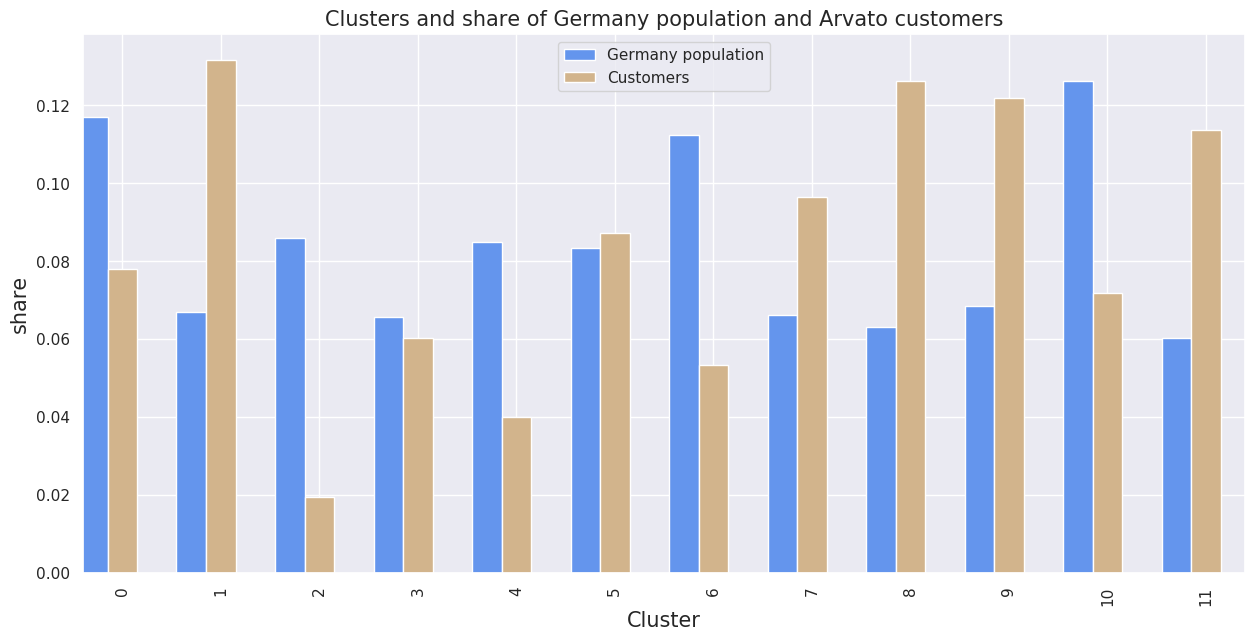

In [63]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

ax = combined_clusters['Germany %'].plot(x=combined_clusters['Cluster'], color='cornflowerblue', kind = 'bar', width=-0.3, align='edge', position=0)
ax = combined_clusters['Customers %'].plot(x=combined_clusters['Cluster'], color='tan', kind = 'bar', width=0.3, align='edge', position=1)
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('share', fontsize=15)
plt.title('Clusters and share of Germany population and Arvato customers', fontsize=15)
plt.legend(('Germany population', 'Customers'))
plt.show()




Relatively, the customers dataset has more variation among clusters than the german dataset. Some clusters of the population are over represented while other are under represented.
* cluster 1,  9, 11, and 8 are highly overrepresented in the customers while cluster 7 is not that much overrepresented. Hence, this clusters should be targete on the campaign as they are highly likely to be our new customers.
* cluster number 0, 2, 4, 6 and 10 are underrepresented in our customers. Hence, future campaing should avoid targeting this clusters as this segment of the population is not interested our product.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [42]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = mailout_train.copy()
mailout_train.shape

(42962, 367)

In [43]:
mailout_train = customer_processor(mailout_train, d)
y = mailout_train['RESPONSE']
mailout_train = mailout_train.drop(['RESPONSE', 'EXTSEL992'], axis=1)
mailout_train.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(42962, 345)

In [44]:
y.shape

(42962,)

In [45]:
mailout_train[categorical_columns] = mailout_train[categorical_columns].astype(str)
mailout_train = column_transformer.fit_transform(mailout_train)

In [46]:
hot_encoded_columns = list(column_transformer.transformers_[0][1].named_steps['One_hot_encoder'].get_feature_names(categorical_columns))
columns = hot_encoded_columns + numerical_columns + binary_clmns 
mailout_train = pd.DataFrame(mailout_train, columns=[columns])

In [50]:
mailout_train['RESPONSE'] = y
mailout_train.shape

(42962, 400)

since the kernel would be changed to use AutoGluon, the processed dataframe for trian and test is saved 
so as to not repeat the above process again

In [51]:

mailout_train.to_csv('mailoutrain.csv')

In [47]:
mailout_test= pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test= mailout_test.copy()

mailout_test= customer_processor(mailout_test, d)

mailout_test= mailout_test.drop([ 'EXTSEL992'], axis=1)
mailout_test.shape

mailout_test[categorical_columns] = mailout_test[categorical_columns].astype(str)
mailout_test = column_transformer.fit_transform(mailout_test)

hot_encoded_columns = list(column_transformer.transformers_[0][1].named_steps['One_hot_encoder'].get_feature_names(categorical_columns))
columns = hot_encoded_columns + numerical_columns + binary_clmns 
mailout_test = pd.DataFrame(mailout_test, columns=[columns])
mailout_test.to_csv('mailout_test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is

In [9]:
mailout_train = pd.read_csv('mailoutrain.csv')
mailout_test = pd.read_csv('mailout_test.csv')
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [10]:
mailout_train.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

## Balancing the dataset

In [11]:
from sklearn.utils import resample
customer_1 = mailout_train[mailout_train['RESPONSE']==1] 
customer_0 = mailout_train[mailout_train['RESPONSE']==0]
customer_1_balanced = resample(customer_1, replace=True, n_samples=42430, random_state=1)
mailout_train = pd.concat([customer_0, customer_1_balanced ])
mailout_train.RESPONSE.value_counts()

0    42430
1    42430
Name: RESPONSE, dtype: int64

In [15]:
y = mailout_train['RESPONSE']
X = mailout_train.drop(['RESPONSE'], axis=1)
X.shape

(84860, 398)

In [16]:
mailout_test.drop(['Unnamed: 0'], axis=1, inplace=True)
#mailout_test

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_reg = LogisticRegression(random_state=10)
grid = GridSearchCV(estimator=logistic_reg, param_grid={}, scoring='roc_auc', cv=10)
grid.fit(X, y);
grid.best_score_


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8225818471082315

#### installing required libraries for using Autogluon

In [18]:
!pip install install pip==21.3.1
!pip install install setuptools==60.0.0 wheel==0.37.0
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing
#!pip install kaggle

  Using cached install-1.3.5-py3-none-any.whl (3.2 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached setuptools-60.0.0-py3-none-any.whl (952 kB)
  Using cached wheel-0.37.0-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 303 kB 30.9 MB/s            
     |███████████

In [19]:
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
label = 'RESPONSE'
metric = 'roc_auc'
time_limit = 600
predictor = TabularPredictor(label=label, eval_metric=metric).fit(mailout_train, time_limit=time_limit)

No path specified. Models will be saved in: "AutogluonModels/ag-20230404_083108/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230404_083108/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 14 23:44:59 UTC 2023
Train Data Rows:    84860
Train Data Columns: 398
Label Column: RESPONSE
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    62994.74 MB
	

[1000]	valid_set's binary_logloss: 0.0701639
[2000]	valid_set's binary_logloss: 0.049559
[3000]	valid_set's binary_logloss: 0.0405312
[4000]	valid_set's binary_logloss: 0.0351967
[5000]	valid_set's binary_logloss: 0.0319681
[6000]	valid_set's binary_logloss: 0.029361
[7000]	valid_set's binary_logloss: 0.0272019
[8000]	valid_set's binary_logloss: 0.0254922
[9000]	valid_set's binary_logloss: 0.023983
[10000]	valid_set's binary_logloss: 0.0228648


	0.9998	 = Validation score   (roc_auc)
	254.7s	 = Training   runtime
	0.34s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 318.85s of the 318.84s of remaining time.


[1000]	valid_set's binary_logloss: 0.0286026
[2000]	valid_set's binary_logloss: 0.0137553
[3000]	valid_set's binary_logloss: 0.0137582


	0.9997	 = Validation score   (roc_auc)
	70.29s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 248.18s of the 248.17s of remaining time.
		scipy.special._ufuncs_cxx does not export expected C variable _export_expit
Fitting model: RandomForestEntr ... Training model for up to 247.77s of the 247.77s of remaining time.
		scipy.special._ufuncs_cxx does not export expected C variable _export_expit
Fitting model: CatBoost ... Training model for up to 247.35s of the 247.35s of remaining time.
	Ran out of time, early stopping on iteration 7359.
	0.9998	 = Validation score   (roc_auc)
	247.78s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the -0.76s of remaining time.
	0.9999	 = Validation score   (roc_auc)
	0.26s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 603.57s ... Best model: "WeightedEnsemble_L2"
T

In [21]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.999860       7.066520  505.088889                0.000662           0.261343            2       True          6
1             CatBoost   0.999804       0.016227  247.781312                0.016227         247.781312            1       True          5
2           LightGBMXT   0.999767       0.335772  254.699452                0.335772         254.699452            1       True          3
3             LightGBM   0.999680       0.099117   70.294787                0.099117          70.294787            1       True          4
4       KNeighborsDist   0.990800       6.665549    0.862108                6.665549           0.862108            1       True          2
5       KNeighborsUnif   0.990800       6.713859    2.346781                6.713859           2.346781 

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'CatBoost': 'CatBoostModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.9907999999999999,
  'KNeighborsDist': 0.9907999999999999,
  'LightGBMXT': 0.99976672,
  'LightGBM': 0.99968032,
  'CatBoost': 0.9998035200000001,
  'WeightedEnsemble_L2': 0.99985984},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'AutogluonModels/ag-20230404_083108/models/KNeighborsUnif/',
  'KNeighborsDist': 'AutogluonModels/ag-20230404_083108/models/KNeighborsDist/',
  'LightGBMXT': 'AutogluonModels/ag-20230404_083108/models/LightGBMXT/',
  'LightGBM': 'AutogluonModels/ag-20230404_083108/models/LightGBM/',
  'CatBoost': 'AutogluonModels/ag-20230404_083108/models/CatBoost/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230404_083108/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'KNeighborsUnif': 2

In [22]:
prob = predictor.predict_proba(mailout_test)[1]

In [24]:
len(prob[prob>0.5])

228

In [17]:
mailout_train.shape

(42962, 401)